November 2021 

In this notebook:

- APIs
- lots of setters, and the @property decorator; no deleters or \_\_eq__
- inheritance?
- some stock knowledge, take a read...

Option Contracts
---

`Option Contracts` can be a bit complicated to understand. 

Their value is **derived from an underlying asset**, for example the price of a stock, and represent the right to buy or sell some quantity of that asset (in general, **100 shares** of the underlying stock) at a future date (**the expiry date**), at a set price (**the 'strike price'**). 

Therefore, each contract has **a purchase price** (premium paid for the ownership of the contract), as well as **an intrinsic value** (the difference between the market price and the strike price * 100) which is reliant on a condition --**that the contract be 'in the money' at time of expiry.- ** 


### Extrinsic and Intrinsic Value

Options Contracts only have market value (`extrinsic value`) if they have `intrinsic value`; a delta between the current share price and the `strike price` of the contract. 

The market value is the `premium`; the price to purchase a contract -- or to sell one. 

The `intrinsic value` is only accessible if a contract is `in the money`:

- A `call contract` is 'in the money' when the stock price is *above* the strike price.

- A `put contract` is 'in the money' when the stock price is *below* the strike price.


### Understanding Ownership

If a contract is NOT in the money, it expires worthless, and the only gain or loss in value is the premium paid for it. We'll get to that in a second, but first, remember:

- The *purchaser* (owner) of the contract receives the intrinsic value, at expiry. They pay a premium to buy the contract.

- The *seller* (or writer) of the contract pays the intrinsic value, at expiry. They received a premium to sell the contract.


### I'd put money it falls...
                ### I call that bet!

And so, if **I sold (or wrote)** a `put` contract, I would be selling someone the right to **sell me 100 shares** at the strike price. If I sold a `call`, I would be selling someone the right to **purchase 100 shares from me** at the strike price. 

**Problem: In order to effectively calculate the returns/losses on an options contract, we must take into account this transaction of shares -- as well as the margin required to perform these transactions.**

We could calculate the returns directly, but I feel that is short-sighted, because we need to hold and reserve `margin shares` in the case of a written `call`; or `reserve capital` when we write a `put`; to cover our potential losses with the broker.

We should have some sort of container for our `Holdings`...

### Package class Objects

To accomplish this task, I propose the following structure:
    
- a `Portfolio` class which can 'hold' shares of different stocks. This layer could have portfolio optimization functionality. Each Portfolio could rely on a different trading strategy, ie. momentum, growth, etc.

- a `Holdings` class which handles the acquisition or sale of all stock-specific assets inside the Portfolio. This layer contains information about the given stock -- past statistics/trends, buy or sell signals, sector, etc. This object should have a reference for `shares held`.

- an `OptionContract` class which handles the value logic of an options contract for a related asset (the `Holdings` object will contain the options spreads, taken from the `yfinance` API.)

# OptionContract object


In [1]:
# importing modules
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,3)
plt.style.use('ggplot')

In [2]:
class OptionContract(): 
    '''a stock-related asset, with an extrinsic and an intrinsic value
    # 1 - extrinsic
     - the initial cost or credit
     
    # 2 - intrinsic
     - the intrinsic value represents the value of 100 shares at the strike price, if purchased, and in the money.
     - represents the negative value of 100 shares at the strike price, if sold, and in the money.
     - otherwise if not 'in the money', the intrinsic value is 0. 
     
    ## functionality ##
     - redefines it's intrinsic value (based on the state of the underlying Holdings object)
         - accepts mutations of its market_price value.
     - returns self.value, when called.
     
    '''
                                            # TODO: instead of market_price, pass the bound Holdings object.
                                            # implement a change to the holdings_object's value, and shares.
                                            # use .pop()?
                                            # also inherit the ticker!
                    
    def __init__(self, premium, strike_price, market_price, contract_size=100, writer=True, call=True):
        # calculating extrinsic value...
        self._writer = writer
        self.contract_size = contract_size
        self._extrinsic_value = None # initialize for conditional logic
        
        ### upon purchase or sale... change the static value of this contract:
        # determine initial credit or debit:
        if self._writer == True: # if sold
            self.extrinsic_value = (premium * contract_size)
        elif self._writer == False: # if purchased
            self.extrinsic_value = -1 * (premium * contract_size)
        #self._extrinsic_value now indicates the premium --> a negative value, if writer==False.
#         print(self._extrinsic_value)
        
        # reference variables
#         self.premium = premium
        self.contract_size = contract_size
        

        # assign necessary variables
        self._strike_price = strike_price
        self._market_price = market_price     ## inherit from a Holdings.market_price?
        self._call = call # True, if the contract is a call. 
                         # False, if the contract is a put.
        
        # call properties to set them...(? i believe this is necessary.)
        self.inthemoney
        self.intrinsic_value
        
    # Intrinsic value logic... 
    # determine the intrinsic value. First, derive whether the contract is in the money.
    # This depends on what kind of contract it is; a call, or a put.
    #inthemoney
    @property 
    def inthemoney(self): 
        # for calls
        if (self.call == True) and self.market_price >= self._strike_price:
            self._inthemoney = True 
        if (self.call == True) and self.market_price < self._strike_price:
            self._inthemoney = False
        
        # for puts
        if (self.call == False) and self.market_price > self._strike_price:
            self._inthemoney = False
        if (self.call == False) and self.market_price <= self._strike_price:
            self._inthemoney = True
        return self._inthemoney
    
        # then calculate the intrinsic value, conditional on the inthemoney attribute
    # intrinsic_value
    @property
    def intrinsic_value(self):
        self.inthemoney # run the check(?)
        # if the contract is 'active'...
        if self.inthemoney == True:
            # it has an intrinsic value..
            curr_val = (self.contract_size * self._market_price)
            # calculate the difference with the strike price..
            strike_val = (self.contract_size * self._strike_price)
            delta = abs(strike_val - curr_val)
            
            # determine the value based on contract ownership and type...
            if (self._call == True) and (self.writer==False):
                # you bought the call
                self._intrinsic_value = delta 
            if (self._call == False) and (self.writer==False):
                # you bought the put
                self._intrinsic_value = delta
         
            if (self._call == True) and (self.writer==True):
                # you sold the call --> you already had margin shares.
                self._intrinsic_value = -1 * delta
            if (self._call == False) and (self.writer==True):
                # you sold the put --> you have to buy the shares at that price!
                # for now, assume you would sell those shares immediately (at that loss). 
                # Later we can look at adding the shares.
                self._intrinsic_value =  -1 * delta
        else:
            return 0 
        return self._intrinsic_value  

    @intrinsic_value.setter
    def intrinsic_value(self, newval):
        self._intrinsic_value = newval
    
        # Attribute Getters/Setters
    # writer
    @property
    def writer(self):
        return self._writer
    # call
    @property
    def call(self):
        return self._call
    
    #extrinsic_value
    @property
    def extrinsic_value(self):
        return self._extrinsic_value
    @extrinsic_value.setter
    def extrinsic_value(self, newval):
        self._extrinsic_value = newval
    
    @property
    def market_price(self):
        return self._market_price
    @market_price.setter
    def market_price(self, newprice):
        self._market_price = newprice
        
    @property
    def value(self):
        return self._extrinsic_value + self.intrinsic_value
    
    def __repr__(self):
        return  str(('Written' if self._writer==True else 'Purchased')) \
                + str(self._strike_price) \
                + str(('Call' if self._call==True else 'Put'))
    
    
    
    def plot_contract(self, low, high, step, plot_me=True, return_me=False, alpha=1):
        curr_price = self.market_price
        values = []
        pricerange = np.arange(low, high, step)
        for price in pricerange:
            self.market_price = price
            values.append(self.value)
        
        if plot_me==True:
            plt.title(('Bought' if self.writer==False else 'Written', 'Call' if self.call==True else 'Put'))
            plt.scatter(pricerange, values, alpha=alpha)
        if return_me==True:
            return values
        # reset market_price 
        self.market_price = curr_price

These contracts are independent entities, which can be plot independently. Below, we will associate them with real options prices, for a specific stock.

We must also account for shares already held (as well as margin shares), in order to have a useful tool.

## Demonstration

Here we will sell a put contract -- remember, that's the right to sell shares at the strike price, even if they fall.

In [4]:
soldput = OptionContract(premium=2.12, strike_price=10, market_price=8.4, writer=True, call=False,) 
soldput.value # current value, given the above market- and strike-price, and premium

52.0

In this scenario, we get paid \\$212 dollars for the contract, up front. That's the premium, or extrinsic value. The unknown other in the transactions receives the right to sell 100 of their shares (currently worth \\$840 dollars) TO US for \\$1000 at the contract's expiry. If the share price stayed totally still, we'd be up \\$52 --> \\$840 + \\$212 - \\$1000.

If the stock went to \\$5 however -- **we got it wrong**:

In [5]:
soldput.market_price = 5
soldput.value

-288.0

Since we've agreed to purchase shares at \\$10, we lose more if the price drops too far. 

If instead we had bought the put, we would have benefited from this price drop.

Remember, Call contracts are only profitable if the stock price at expiry is *above* the strike price.

Since we're dealing with puts here, remember that they are only profitable if the stock price is *below* the strike price.

We don't own the contract, we are bound to the contract as it's writer -- and so as the stock price drops; the intrinsic value of the contract rises; and we have to pay up more bucks.

---

**Since this is a put contract we wrote and sold**, we have agreed to purchase the underlying shares from the contract holder at the strike price (\\$10).

**As the price of the asset rises towards the strike price**, it's intrinsic value drops.

**As the price of the asset drops away from the strike price**, we stand to lose more money. This is because we've agreed to purchase the shares at the strike price, \\$10. Since this risk is open-ended, it must be supplemented at the broker with some sort of margin.

**If the price of the asset is at or above the strike price** of the contract, at the expiry of the contract, we make maximum profit -- the premium on our sold contract.

The reverse would be true in all cases if we had **purchased and owned** the contract. 

# plotting soldput

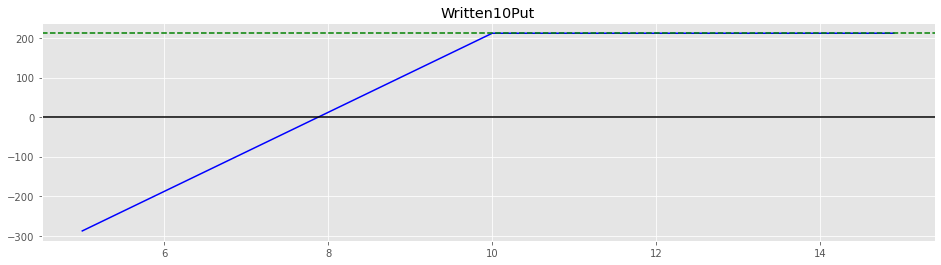

In [6]:
def plot_contract(contract, low, high):
    premium = contract.extrinsic_value
    values = []
    price_range = np.arange(low, high, 0.1)
    for i in price_range: # iterate through price values
        contract.market_price = i
        values.append(contract.value)
    plt.figure(figsize=(16, 4))
    plt.title(f'{contract}')

    plt.plot(price_range, values, color='blue')
    plt.axhline(premium, color='green', ls='--')
    plt.axhline(0, color='black')

plot_contract(soldput, 5, 15)

At any price point where the contract is exercised and we are forced to purchase 100 shares of the underlying asset, we would like to interact with our Holdings object in a particular way.
    
    - This interaction should be initially designed to be user-friendly.
    - If the basic purpose is to examine the risk and reward of options contracts:
        - we will be calling this interaction to calculate the value of the Holdings over a range of market_prices
        - 


If there was a margin for sold puts, it would entail having sufficient capital to purchase the entirety of the contract, and acquiring the underlying shares (to be held in the Holdings object).

# plotting soldcall

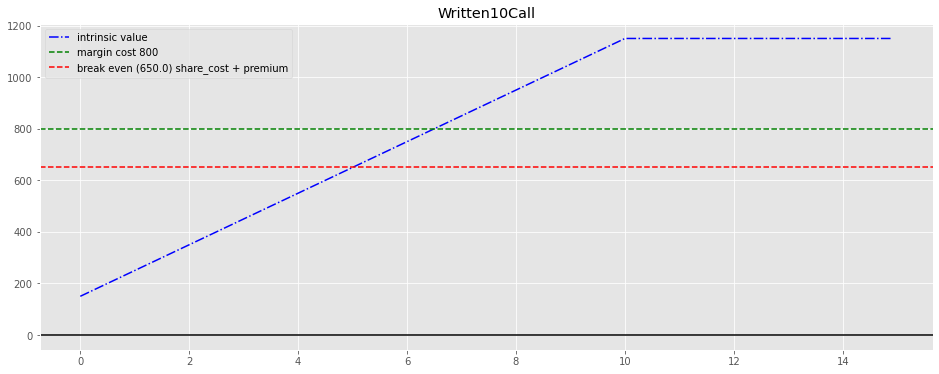

In [7]:
# margin shares with a sold call; purchased at the initial market_price ($8); including premium($150) 
soldcall =  OptionContract(premium=1.5, strike_price=10, market_price=8, writer=True, call=True,) 



def plot_sold_call(contract):
    margin_cost = contract.market_price * 100 # the price of margin shares
                                            # could also represent the reserve capital
    premium = contract.extrinsic_value  # most of the profit...
    
    ## recording values over price range
    share_value = []
    contract_value = []
    total_value = []
    price_range = np.arange(0, 15, 0.1) # TODO: non-naive from Holdings
    
    
    ## iterating through market_prices
    plt.title(contract)
    for i in price_range: # iterate through price values
        contract.market_price = i
        contract_value.append(contract.value)
        share_value.append(100 * contract.market_price)
        total_value.append(contract.value + (100*contract.market_price))
        
#     plt.plot(price_range, share_value, label= 'share value', ls=':')
#     plt.plot(price_range, contract_value, label='contract value', color='purple')
    plt.plot(price_range, total_value, label='intrinsic value', ls='dashdot', color='blue')
    
    plt.axhline(margin_cost, color='green', ls='--', label=f'margin cost {margin_cost}')

    plt.axhline((margin_cost - premium), color='red', ls='--', label=f'break even ({margin_cost - premium}) share_cost + premium')
    plt.axhline(0, color='black')
    plt.yticks()
    plt.legend()
    plt.show()
    
plt.subplots(figsize=(16,6))
plot_sold_call(soldcall)

Note that the increase in the value of our shares is directly proportionate to the reduction in the value of our contract.

The difference here lies in the required capital necessary to make this transaction.

Our 'entry point' for purchased shares determines the overall profitability

Problem: Accounting for Margin Shares
---

Each contract has different steps to calculate its value at resolution:

    Calls:
        Written :
            We must have margin shares to appease the broker
        Purchased :
            We will 'call away' the shares at the strike price
    Puts:
        Written:
            We must have sufficient capital to purchase the shares at the strike price
        Purchased:
            We will sell shares at the strike price

So, when we write a call, we need to purchase shares at the current market price and reflect their value in our analysis as well.

Moreover, to validate the purchase or sale of a contract, we need to have sufficient capital allocated to the stock.

# Holdings object

In [8]:
class Holdings():
    '''
    loads relevant data about a given stock
    
    elegantly handles contract and share purchases
        
    - allow purchasing/selling of the underlying stock
    - allow purchasing(and resolution?) of contracts
        - require margin shares for written calls; their value will increase as market_price increases.
        - 'settle' any written puts by purchasing shares at strike, if in the money --> 
                                this requires restructuring of the logic in OptionsContract

    accepts:
    ticker : valid yfinance ticker
        option_dates : 0-indexed options 'dates', available through yfinance
    returns:
        calls:
        puts:  options sheets for the stock
        
        value: the total value of capital, shares held, and contracts at the current market_price
    
    '''
    def __init__(self, ticker):
        
        # stock information
        self._ticker = ticker
        self.stock = yf.Ticker(ticker)
        self._market_price = self.stock.info['previousClose']
        print(f'fetched data for {self._ticker}...yesterdays price: {self._market_price}')             

        # options stuff
        self.option_dates = list(self.stock.options)
        self.option_date = 0 # zero-indexing into option_dates
        self.opt = self.stock.option_chain(self.option_dates[self.option_date]) # initialize at 0
        self.calls = self.opt.calls.copy()
        self.puts = self.opt.puts.copy()
              
        # container attributes
        self.capital = 0 # debit this when purchasing shares or contracts; 
                         # credit this when writing contracts or selling shares;
        self._shares = 0
        self.contracts = [] # to hold 'OptionContract' objects...
        
    @property
    def ticker(self):
        return self._ticker
    @property
    def market_price(self):
        return self._market_price
    @market_price.setter
    def market_price(self, newprice):
        self._market_price = newprice
        # adjust the market price (therefore intrinsic value) of contract objects held;
        for x in self.contracts:
            x.market_price = newprice
    
    # capital
#     @property
#     def capital(self):
#         return self._capital
#     @capital.setter
#     def capital(self, value):
#         assert self._capital + value >= 0, 'capital less than 0'
#         self.capital = self._capital + value
        
        
    @property
    def intrinsic_value(self): # the worth of shares plus the worth of contracts, given a set market_price
        return round((self._shares * self._market_price) + sum([x.value for x in self.contracts]), 2)
 
    @property
    def shares(self):
        return self._shares
    @shares.setter
    def shares(self, newval): #newval IS self.shares, when assigning using +=
        assert newval >= 0, 'You cannot have negative share count'
        self._shares = newval
    

    @property
    def value(self):     
        return (self.intrinsic_value + self.capital)
    
    def buy_shares(self, num_shares):
        cost = num_shares * self.market_price # adjust capital based on current market_price -->
        assert self.capital - cost >= 0, f"not enough to purchase {num_shares} of {self.ticker}"
        self.shares = self.shares + num_shares
        self.capital = self.capital - cost
        print(f'buying {num_shares} at {self.market_price} for {cost}')

    def sell_shares(self, num_shares):
        cost = num_shares * self.market_price
        assert self.shares - num_shares >= 0, f'cannot sell {num_shares}, only {self.shares} available.'
        self.shares = self.shares - num_shares
        self.capital = self.capital + cost
        print(f'selling {num_shares} at {self.market_price} for {cost}')
    
    @property
    def req_margin_shares(self):
        sold_calls = len([x for x in self.contracts if (x.writer == True) and (x.call==True)])
        return 100 * sold_calls

    def add_contract(self, strike_price, call=True, writer=True):
#         if (writer == True) and (call==True):
#             assert self.req_margin_shares >= self.shares, 'you must have sufficient shares to cover margin'
        calls = self.calls
        puts = self.puts 
        
        if call==True:
            # find the premium. TODO: take the mean of ask/bid
            premium = float(calls[calls['strike'] == strike_price]['lastPrice'].values)
            if writer == True:
                print(f'you agreed to sell 100 shares of {self.ticker} at {strike_price}, and earned {premium*100}')
                print(f'you need to have 100 shares available to sell; you will receive {strike_price * 100} for this transaction')
                self.contracts.append(OptionContract(premium, strike_price, self.market_price, call=True, writer=True))    
            elif writer == False:
                print(f'you purchased the right to sell 100 shares of {self.ticker} at {strike_price}, for {premium*100}')
                self.contracts.append(OptionContract(premium, strike_price, self.market_price, call=True, writer=False))

            
        elif call==False:
            premium = float(puts[puts['strike'] == strike_price]['lastPrice'].values)      
            if writer == True:
                print(f'you agreed to buy 100 shares of {self.ticker} at {strike_price}, and earned {premium*100}')
                print(f'you need to have capital available to make this purchase. it will cost {strike_price * 100} and you will receive 100 shares')
                self.contracts.append(OptionContract(premium, strike_price, self.market_price, call=False, writer=True)) 
            elif writer == False:
                print(f'you purchased the right to sell 100 shares of {self.ticker} at {strike_price} for {premium*100}')
                self.contracts.append(OptionContract(premium, strike_price, self.market_price, call=False, writer=False))

        
    def resolve_contracts():
        prior_price = self.market_price # to reset after spread.
        for idx, contract in enumerate(self.contracts):
            self.contracts.pop(idx)
            
            if contract.inthemoney == True:
                
                if contract.writer == True: # sold contract 
                    
                    if contract.call == True:
                        self.market_price = contract._strike_price
                        self.sell_shares(100)
                    elif contract.call == False:
                        self.market_price = contract._strike_price
                        self.buy_shares(100)
                        
                elif contract.writer == False: # bought contract
                    
                    if contract.call == True:
                        self.market_price = contract._strike_price
                        self.buy_shares(100)
                    elif contract.call == False:
                        self.market_price = contract._strike_price
                        self.sell_shares(100)
                        
        self.market_price = prior_price

#     def reset_object(self, capital=2500):
#         'reset the extrinsic value, shares, and contracts of a Holdings object'
#         self.shares = 0
#         self.contracts.clear()
#         self.capital = capital

#         self._market_price = 8.94 #self.stock.info['previousClose']
    
    def __repr__(self):
        return str(self._ticker) + " Holdings"
    

In [9]:
SLI = Holdings('SLI')
# allocate capital
SLI.capital = 800
# buy shares
SLI.buy_shares(100)

SLI.capital, SLI.intrinsic_value, SLI.value
# the free capital, intrinsic value, and total value of our Holdings object: the value of all shares and contracts;

fetched data for SLI...yesterdays price: 6.39
buying 100 at 6.39 for 639.0


(161.0, 639.0, 800.0)

In [10]:
SLI.shares

100

In [11]:
SLI.add_contract(7.5, call=True, writer=True)
SLI.add_contract(10, call=False, writer=False)

you agreed to sell 100 shares of SLI at 7.5, and earned 20.0
you need to have 100 shares available to sell; you will receive 750.0 for this transaction
you purchased the right to sell 100 shares of SLI at 10 for 364.0


In [74]:
SLI.contracts

[Written7.5Call, Purchased10Put]

# Adding a contract to Holdings object

In [75]:
soldsli750put = OptionContract(.5, 7.5, SLI.market_price, writer=True, call=False)

In [76]:
# SLI.add_contract(soldsli750put) # gain $50 from the premium

In [77]:
SLI.value

831.0

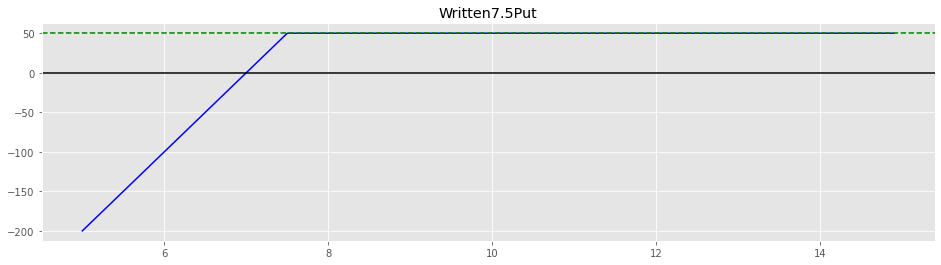

In [78]:
plot_contract(soldsli750put, 5, 15)

In [79]:
SLI.market_price = 7.5
SLI.value

831.0

Great. We could calculate the cost and value of bought margin shares easily, and match it with our contracts.

However, since we're here... let's see if we can create another class, which might represent all of our holdings related to one stock. I'd like to implement some kind of inheritance or polymorphism here (some common properties; for example to calculate the value at a given market price).

From the OptionContract object above, we have         
- extrinsic value
- intrinsic value
- contract_size (# implied shares)
- value --> a summation of the intrinsic and extrinsic value.

However, if we wanted to hold other information about the stock (in memory, or in some kind of filesystem), at some point we will need to parse some data (At very least, to find the market price!). This `Holdings` class could be responsible for calculating the value of all contracts and shares related to a specific stock.

---

In [80]:
def resolve_contracts(self):
    prior_price = self.market_price
    for idx, contract in enumerate(self.contracts):
        print(contract)
        self.contracts.pop(idx)
        if contract.inthemoney == True:
            if contract.writer == True:
                if contract.call == True:
                    self.market_price = contract._strike_price
                    self.sell_shares(100)
                elif contract.call == False:
                    self.market_price = contract._strike_price
                    self.buy_shares(100)
                self.market_price = prior_price
            elif contract.writer == False:
                if contract.call == True:
                    self.market_price = contract._strike_price
                    self.buy_shares(100)
                elif contract.call == False:
                    self.market_price = contract._strike_price
                    self.sell_shares(100)
        

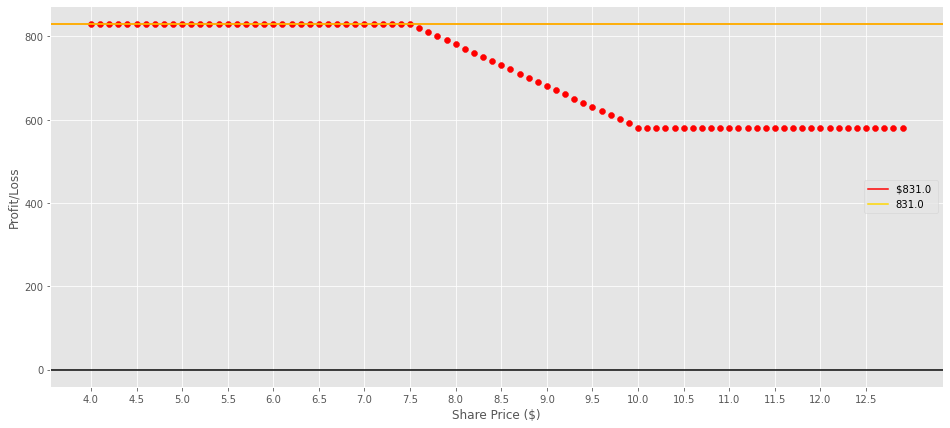

In [81]:
def plot_spread(holdings_obj):
    ''' return a meaningful representation of the calls/puts sheets held in the Holdings object'''
    h=holdings_obj
    _ = h.market_price # save and (eventually) restore the market_price from before the call.
    breakeven = holdings_obj.value # initial invested capital
    pricerange = np.arange(4,13,0.1) ### THIS NEEDS TO BE ABSTRACTED

    # container to check most profitable section. The plotted price.
    values = []
    top_pricepoint = 0
    top_val = 0
#     bot_pricepoint = 0

#     bot_val = breakeven
    for price in pricerange: # iterate through prices in pricerange
        h.market_price = price # changing the value of the underlying asset
        
        if h.value > top_val: # if the value of Holdings is greater than previous top_val..
            top_pricepoint, top_val = price, h.value
#         elif h.value < bot_val:
#             print(h.value)
#             bot_pricepoint, bot_val = price, h.value
            
            
        values.append(h.value)# regardless, append the current total value (versus price)
    h.market_price = _ # reset the market_price.
    
    plt.figure(figsize=(16,7))    
    plt.ylabel('Profit/Loss')
    plt.xlabel('Share Price ($)')

    for price, value in zip(pricerange, values):
        if value > breakeven:
            plt.scatter(price, value, c='green') ## profitable points noted in green
        else:
            plt.scatter(price, value, c='red') ## non-profitable points noted in red
            
    plt.axhline(breakeven, color='red', label=f'\${breakeven} ')

    
    # conditional 
    plt.xticks([x for x in pricerange[::5]])
#     plt.yticks([x for x in range(-3000, 3000, 200)])
    plt.axhline(0, color='black')
    plt.axhline(top_val, color='gold', label=f'{round(top_val, 1)}')
#     plt.axhline(bot_val, color='cyan', label=f'{round(bot_val, 1)}')

#     plt.axhspan(xmin=0, xmax=max(pricerange), ymin=0, ymax=top_val, alpha=0.2, color='gold')
#     plt.axhspan(xmin=0, xmax=max(pricerange), ymin=min(values), ymax=0, alpha=0.2, color='red')
    plt.legend()
#     plt.savefig('for guy.png')
    plt.show()

plot_spread(SLI)

### UTILIZING CALL AND PUT OPTION CHAINS

In [82]:
h = Holdings('SLI') 


fetched data for SLI...yesterdays price: 6.96


In [83]:
strikes, callprices, putprices = h.calls['strike'], h.calls['lastPrice'], h.puts['lastPrice']

In [84]:
df = pd.DataFrame([callprices, putprices], index=['calls', 'puts']).T
df.set_index(strikes, inplace=True)
df

,calls,puts
strike,,
2.5,4.50,0.23
5.0,2.15,1.20
7.5,0.57,3.30
10.0,0.06,6.17
12.5,0.05,NaN
15.0,0.05,NaN


## Plotting full spread of Options for a stock

This function calls for the yfinance object directly, but could easily be implemented in the class. It parses the available contract dates, calls the first value (contract_date == 0) and then finds the value of each type of contract at that market price. 

lowest and highest strike: 99.0 481.0


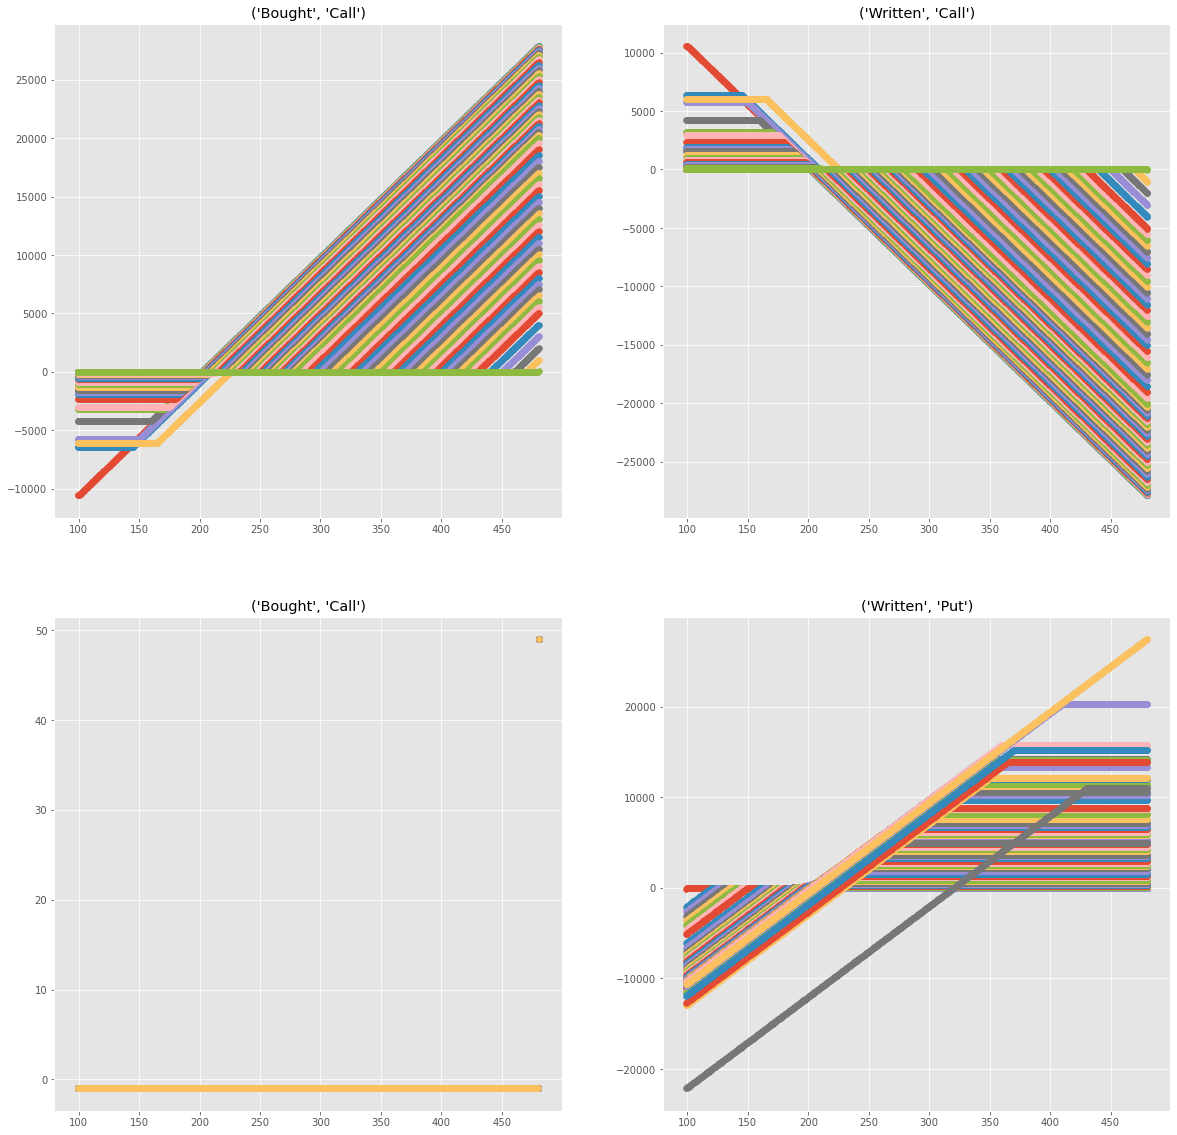

In [31]:
def plot_spreads(ticker, contract_date=0):
    
    stock = yf.Ticker(ticker)
    prev_close = stock.info['previousClose']
    options_dates = list(stock.options)
    mydate = options_dates[contract_date]  ### NEXT DATE IS 0-INDEXED VALUE FROM OPTIONS_DATES
    opt = stock.option_chain(mydate)
    # data available via: opt.calls, opt.puts
    calls = opt.calls
    puts = opt.puts
    

#     std = calls['strike'].std()
    high = calls['strike'].max() + 1
    low = (calls['strike'].min() - 1)
    if low < 0:
        low=0
    print('lowest and highest strike:', low, high)
    
    ### CALLS###
    # bought calls
    prices = calls['lastPrice']
    strikes = calls['strike']
    bought_calls = []
    for price, strike in list(zip(prices, strikes)):
        boughtcall=OptionContract(price, strike, prev_close, call=True, writer=False)
        bought_calls.append(boughtcall)

    # sold calls
    sold_calls = []
    for price, strike in list(zip(prices, strikes)):
        soldcall=OptionContract(price, strike, prev_close, call=True, writer=True)
        sold_calls.append(soldcall)
        
        
    ### PUTS ###
    # bought puts
    prices = puts['lastPrice']
    strikes = puts['strike']
    bought_puts = []
    for price, strike in list(zip(prices, strikes)):
        boughtput=OptionContract(price, strike, prev_close, call=False, writer=False)
        bought_puts.append(boughtcall)


    # written puts
    sold_puts = []
    for price, strike in list(zip(prices, strikes)):
        soldput=OptionContract(price, strike, prev_close, call=False, writer=True)
        sold_puts.append(soldput)

    all_options = [bought_calls] + [sold_calls] + [bought_puts] + [sold_puts]

    plt.subplots(2, 2, figsize=(20, 20))
    for idx, lst in enumerate(all_options):
        plt.subplot(2,2 ,idx+1)
        labels = []
        for c in lst:
            c.plot_contract(low, high, 0.5)
            labels.append(c)
#         plt.legend(labels=labels, loc='best')
    plt.show()
    
plot_spreads('FB')

Note that the purchased call plot is broken because the `market_value` is shifting along with the intrinsic value of the contract... it's consistently representing it's value as the cost of the contract, because the value of shares is not included in the calls. Sold puts currently do not allocate shares --

## Another Example for testing...

In [86]:
# creating all_options list for testing..
boughtput=OptionContract(0.65, 7.5, 8.4, call=False, writer=False)
boughtcall=OptionContract(4, 5, 8.4, call=True, writer=False)
soldput=OptionContract(4, 5, 8.4, call=False, writer=True)
soldcall=OptionContract(4, 5, 8.4, call=True, writer=True)

all_options = [boughtput, boughtcall, soldput, soldcall]

## bought calls

In [ ]:

boughtcall=OptionContract(3.4, 10, 8.87, call=True, writer=False)

# pay $340
h.add_contract(boughtcall)
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 10
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares)
### This still needs work.

## sold puts

In [ ]:
#
h.reset_object()

# soldcall=OptionContract(4.14, 5, 8.87, call=True, writer=True)
soldput=OptionContract(3.4, 10, 8.87, call=False, writer=True)

# make $340 --> currently paying 1.13
# h.add_contract(soldcall)
h.add_contract(soldput)
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 10
print(sum([x.value for x in h.contracts]), h.value, h.shares)
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares)


## sold calls

Purchased 100 shares for margin, at market price..

In [ ]:
#
h.reset_object()
soldcall=OptionContract(1.4, 10, 8.87, call=True, writer=True)

# make $140 --> currently paying 0
# h.add_contract(soldcall)
h.add_contract(soldcall)
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 8.87
h.market_price = 15
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 15 --> they want the shares.
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 5


## bought puts

In [ ]:
#
h.reset_object()
soldcall=OptionContract(1.4, 10, 8.87, call=False, writer=False)

# make $140 --> currently paying 0
# h.add_contract(soldcall)
h.add_contract(soldcall)
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 8.87
h.market_price = 15
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 15 --> they want the shares.
h.market_price = 5
print(sum([x.value for x in h.contracts]), h.value, h.shares) # at 5


### Final example 

# Portfolio object


In [92]:
class Portfolio():
    '''A container for Holdings objects, optimization
    
        accepts:
        name : the name of the portfolio/strategy
        init_capital : the capital available for the strategy.
        
    '''

    def __init__(self, name='Portfolio', init_capital=0):
        self.free_capital = init_capital
        self.name = name
        self.holdings = [] # list of Holdings objects
        self._value = init_capital # initialize the value as equal to the capital allocation.
        
        
        
    @property
    def ticker_list(self):
        return [x.ticker for x in self.holdings] 
    @property
    def price_list(self):
        return [x.value for x in self.holdings]
    @property
    def share_list(self):
        return [x.shares for x in self.holdings]
    
    @property
    def total_value(self):
        self._value = sum([x.value for x in self.holdings]) + self.free_capital
        return self._value
        
    def transfer_funds(self, holdings_obj, amount):
        self.free_capital = self.free_capital - amount
        holdings_obj.capital = holdings_obj.capital + amount

We expect our Holdings objects to have:

.ticker, .capital, .value, and .shares methods.  This is a rudimentary architechture.

Our Portfolio class has  attributes:

In [93]:
Portfolio.__dict__

mappingproxy({'__module__': '__main__',
              '__doc__': 'A container for Holdings objects, optimization\n    \n        accepts:\n        name : the name of the portfolio/strategy\n        init_capital : the capital available for the strategy.\n        \n    ',
              '__init__': <function __main__.Portfolio.__init__(self, name='Portfolio', init_capital=0)>,
              'ticker_list': <property at 0x2a6c9e19810>,
              'price_list': <property at 0x2a6ca245900>,
              'share_list': <property at 0x2a6ca245d10>,
              'total_value': <property at 0x2a6ca245810>,
              'transfer_funds': <function __main__.Portfolio.transfer_funds(self, holdings_obj, amount)>,
              '__dict__': <attribute '__dict__' of 'Portfolio' objects>,
              '__weakref__': <attribute '__weakref__' of 'Portfolio' objects>})

In [94]:
port = Portfolio('TECH', 5000)
port.total_value

5000

### buying and selling shares

In [95]:
port_SLI = Holdings('SLI')

fetched data for SLI...yesterdays price: 6.96


In [96]:
port.holdings.append(port_SLI)

In [97]:
port.transfer_funds(port_SLI, 2500)
port_SLI.buy_shares(100)

buying 100 at 6.96 for 696.0


### PlotSpread class WIP

In [ ]:
SLI = Holdings('SLI')

SLI.add_contract(soldcall)
SLI.add_contract(soldput)

The below class is total WIP

In [ ]:
class PlotSpread:
    ''' a functional 'class' dedicated to analysis of a set of contracts
    '''
    
    def __init__(self, holdings_obj):
        
        h = holdings_obj
        price_range = np.arange(0, 15, 0.1) # TODO: non-naive from Holdings
        
        #         # set a line at your current capital
#         h.capital + h.shares + h.contracts
        
        ## breakeven; with margin;
        ## hardcode the original margin cost
#         self.margin = None
        
    
        

        for contract in h.contracts:
            #
            share_value = []
            contract_value = []
            total_value = []
            total_margin = 0

            # evaluate margin; not necessary for purchased contracts?
            if (contract.writer==True):
                if contract.call==True:
                    total_margin += h.market_price * 100 # 'purchase' margin shares @CURRENT market_price--------------->
                if contract.call==False:  
                    total_margin += contract._strike_price * 100 # represent the reserve capital; no additional value.     
            
                premium = contract.extrinsic_value

        ## recording values over price range

        

            ## iterating through market_prices
            plt.title(h)
            for i in price_range: # iterate through price values
                contract.market_price = i
                contract_value.append(contract.value)
                share_value.append(100 * contract.market_price)
                total_value.append(contract.value + (100*contract.market_price))# <------------- own shares @ the new price
            
            ## plotting results
            plt.plot(price_range, share_value, label= 'share value')
            plt.plot(price_range, contract_value, label='contract value', color='purple')

            plt.plot(price_range, total_value, label='total', ls='dashdot', color='blue')
            plt.axhline((total_margin-premium), color='green', ls='--', label=f'break even ({total_margin} - {premium}) share_cost; premium')
            plt.axhline(0, color='black')
            plt.yticks()
            plt.legend()
            plt.show()

        plt.subplots(figsize=(16,6))

In [ ]:
class PlotSpread:
    ''' a functional 'class' dedicated to analysis of a set of contracts, rather than storing their values in a portfolio
    
    '''
    
    def __init__(self, holdings_obj):
        
        h = holdings_obj
        price_range = np.arange(0, 15, 0.1) # TODO: non-naive from Holdings
        
        #         # set a line at your current capital
#         h.capital + h.shares + h.contracts
        
        ## breakeven; with margin;
        ## hardcode the original margin cost
#         self.margin = None
        
        share_values = []
        contract_values = []
        total_values = []
        total_margin = 0
        total_premium = 0

        for contract in h.contracts:
            #
            share_value = []
            contract_value = []
            total_value = []

            # evaluate margin; not necessary for purchased contracts?
            if (contract.writer==True):
                if contract.call==True:
                    total_margin += h.market_price * 100 # 'purchase' margin shares @CURRENT market_price--------------->
                if contract.call==False:  
                    total_margin += contract._strike_price * 100 # represent the reserve capital; no additional value.     
            
                total_premium += contract.extrinsic_value

        ## recording values over price range
        
        

            ## iterating through market_prices
            plt.title(h.contracts)
            for i in price_range: # iterate through price values
                contract.market_price = i
                contract_value.append(contract.value)
                share_value.append(100 * contract.market_price)
                total_value.append(contract.value + (100*contract.market_price))# <------------- own shares @ the new price
        
            share_values.append(np.array(share_value))
            total_values.append(np.array(total_value))
            contract_values.append(np.array(contract_value))
        
        
        contract_totals = [np.zeros(len(contract_values[0]))]
        for x in contract_values:
            contract_totals += x
            
        share_totals = [np.zeros(len(share_values[0]))]
        
        for x in share_values:
            share_totals += x

        totals = [np.zeros(len(total_values[0]))]
        for x in total_values:
            totals += x

        plt.plot(price_range, share_totals.ravel(), label= 'share value')
        plt.plot(price_range, contract_totals.ravel(), label='contract value', color='purple')
        plt.plot(price_range, totals.ravel(), label='total', ls='dashdot', color='blue')
        
        plt.axhline((total_margin - total_premium), color='green', ls='--', label=f'invested {total_margin} - {total_premium}')
        plt.axhline(0, color='black')
        plt.yticks()
        plt.legend()
        plt.show()
        
plt.subplots(figsize=(16,6))
        
PlotSpread(SLI)

# Trying a functional approach to contracts 

In [ ]:
class Contract:
    '''contract'''
    def __init__(self,
                 premium, #load from Holdings
                 strike, #loaded from Holdings?
                 market_price, #loaded frmo Holdings
                contract_size=100, # REGULAR
#                 call=True, # TRUE if a call, FALSE if a Put
#                 writer=True, # TRUE if contract is NOT OWNED
                ):
    
        self.premium = premium
        self.strike_price = strike
        self.market_price = market_price
        self.contract_size = contract_size
        
    def measure(self):
        self.calculate_money_worth()
        
    def cut(self):
        self.calculate_shares_and_money()

In [88]:
SLI.puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SLI220218P00005000,2022-01-28 17:58:58,5.0,0.23,0.0,0.0,0.0,0.0,84,0,0.500005,False,REGULAR,USD
1,SLI220218P00007500,2022-01-28 20:29:30,7.5,1.20,0.0,0.0,0.0,0.0,636,0,0.000010,True,REGULAR,USD
2,SLI220218P00010000,2022-01-28 17:44:22,10.0,3.30,0.0,0.0,0.0,0.0,14,0,0.000010,True,REGULAR,USD
3,SLI220218P00012500,2022-01-18 19:57:44,12.5,6.17,0.0,0.0,0.0,0.0,2,0,0.000010,True,REGULAR,USD


In [ ]:
####JANKY

msft = Holdings('MSFT') ### JUNK

written_call = OptionContract(4, 300, msft)
written_put = OptionContract(4, 330, msft, call=False)
bought_put = OptionContract(4, 330, msft, writer=False, call=False)
bought_call = OptionContract(4, 330, msft, writer=False)

asset_list = [written_call, 
              written_put,
              bought_put, 
              bought_call]



[msft.contracts.append(x) for x in asset_list]

In [90]:
msft.__dict__

{'_ticker': 'MSFT',
 'stock': yfinance.Ticker object <MSFT>,
 '_market_price': 299.84,
 'option_dates': ['2022-02-04',
  '2022-02-11',
  '2022-02-18',
  '2022-02-25',
  '2022-03-04',
  '2022-03-11',
  '2022-03-18',
  '2022-04-14',
  '2022-05-20',
  '2022-06-17',
  '2022-07-15',
  '2022-08-19',
  '2022-09-16',
  '2023-01-20',
  '2023-03-17',
  '2023-06-16',
  '2024-01-19'],
 'option_date': 0,
 'opt': Options(calls=         contractSymbol       lastTradeDate  strike  lastPrice  bid  ask  \
 0   MSFT220204C00200000 2022-01-28 18:06:24   200.0     103.30  0.0  0.0   
 1   MSFT220204C00210000 2022-01-27 14:31:27   210.0      92.57  0.0  0.0   
 2   MSFT220204C00215000 2022-01-25 20:02:21   215.0      79.59  0.0  0.0   
 3   MSFT220204C00220000 2022-01-28 14:30:01   220.0      80.65  0.0  0.0   
 4   MSFT220204C00225000 2022-01-21 17:28:04   225.0      77.50  0.0  0.0   
 ..                  ...                 ...     ...        ...  ...  ...   
 60  MSFT220204C00405000 2022-01-28 16:23:01 

In [ ]:
print(type(bought_put))
isinstance(bought_put, Holdings)